In [122]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')
sys.path.append('/usr/users/fsimone/tejaas')
from iotools import readgtf

base_dir = "/cbscratch/franco/datasets"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
import collections

GENEINFO_FIELDS = ['name', 'ensembl_id', 'chrom', 'start', 'end']
class GeneInfo(collections.namedtuple('_GeneInfo', GENEINFO_FIELDS)):
    __slots__ = ()

def read_TFannot(infile):
    TF_list = list()
    with open(infile) as instream:
        next(instream)
        for line in instream:
            arr = line.rstrip().split()
            TF_list.append(GeneInfo(ensembl_id=arr[0], chrom=int(arr[1]), start=int(arr[2]), end=int(arr[3]), name=arr[4]))
    return TF_list
            

In [124]:
TF_annot = read_TFannot("../TF_annotation.txt")

In [125]:
import collections
TF_dict = collections.defaultdict(dict)
for g in TF_annot:
    TF_dict[g.chrom][g.ensembl_id] = g.start

In [126]:
def search_TF(TF_dict, chrom, pos):
    TSS_distance = 1e10
    cisTF = None
    found = False
    for TF in TF_dict[chrom].keys():
        dist = pos - TF_dict[chrom][TF]
        if np.abs(dist) < TSS_distance:
            TSS_distance = dist
            cisTF = TF
            found = True
    if not found:
        print(chrom, pos)
    return TSS_distance, cisTF

search_TF(TF_dict, 1, 3000000)

(14269, 'ENSG00000142611')

In [127]:
import mpmath

mpmath.mp.dps = 100
def pval(x): return float(mpmath.log10(1 - 0.5 * (1 + mpmath.erf(x/mpmath.sqrt(2)))))

SNPRES_FIELDS = ['rsid', 'chrom', 'pos', 'logp', 'TFdist', 'TFname']
class SNPRes(collections.namedtuple('_SNPRes', SNPRES_FIELDS)):
    __slots__ = ()
       
        
def tejaas(filepath, chrom):
    res = list()
    with open(filepath, 'r') as mfile:
        next(mfile)
        for line in mfile:
            arr   = line.strip().split("\t")
            rsid  = arr[0]
            pos   = int(arr[1])
            p     = float(arr[5])
            q     = float(arr[2])
            mu    = float(arr[3])
            sigma = float(arr[4])
            if sigma == 0:
                continue
            logp  = np.log10(p) if p != 0 else pval( (q - mu) / sigma)
            res.append(SNPRes(rsid=rsid, chrom=chrom, pos=pos, logp=-logp, TFdist=None, TFname=None))
    return res

In [138]:
from utils import utils
tissue_file = "/usr/users/fsimone/trans-eqtl-pipeline/main/tissues.txt"
tissuenames, descriptions = utils.read_tissues(tissue_file)
tissues = ["gtex-"+t for t in tissuenames]

datadir = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v6_norm//"

# chrms = [6, 7, 8]
chrms = np.arange(1,23)
snp_res_dict = collections.defaultdict(dict)
snp_res_dict_top = collections.defaultdict(dict)
expressions = ["norm"] #["lmcorrected_age"] #
methods = ["tejaas"] #, "tejaas_rand"]
sbs = ["0.05"]#, "0.1"]
LD = False
isworst = False
for sb in sbs:
    for expr in expressions:
        snp_res_dict[sb][expr] = collections.defaultdict(dict)
        snp_res_dict_top[sb][expr] = collections.defaultdict(dict)
        for tissue in tissues:
            snp_res_dict[sb][expr][tissue] = collections.defaultdict(dict)
            snp_res_dict_top[sb][expr][tissue] = collections.defaultdict(dict)
            for method in methods:
                snp_res = list()
                snp_res_top = list()
                print(tissue, method, expr, end=" ")
                for chrom in chrms:
                    print(chrom, end=" ")
                    inputfile = os.path.join(datadir, expr, tissue, method, "permnull_sb"+sb, "chr"+str(chrom), "rr.txt")
                    # snp_res += tejaas(inputfile, chrom)

                    if LD:
                        if isworst:
                            inputfile = os.path.join(datadir, expr, tissue, method, "permnull_sb"+sb, "chr"+str(chrom), "rr.txt.top2000.ld.worst")
                        else:
                            inputfile = os.path.join(datadir, expr, tissue, method, "permnull_sb"+sb, "chr"+str(chrom), "rr.txt.top2000.ld")
                    else:
                        inputfile = os.path.join(datadir, expr, tissue, method, "permnull_sb"+sb, "chr"+str(chrom), "rr.txt.top2000")
                    snp_res_top += tejaas(inputfile, chrom)
                print("")
                # snp_res_dict[sb][expr][tissue][method] = snp_res
                snp_res_dict_top[sb][expr][tissue][method] = snp_res_top

gtex-aa tejaas norm 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
gtex-as tejaas norm 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
gtex-at tejaas norm 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
gtex-esom tejaas norm 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
gtex-esomu tejaas norm 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
gtex-fib tejaas norm 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
gtex-lu tejaas norm 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
gtex-ms tejaas norm 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
gtex-nt tejaas norm 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
gtex-sse tejaas norm 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
gtex-thy tejaas norm 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
gtex-wb tejaas norm 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 


In [129]:
from operator import attrgetter

def get_all_distances(snplist, TF_dict, nsnps = 10000):
    snp_objects = list()
    ixs = np.random.randint(0, len(snplist), nsnps)
    for i in ixs:
        snp = snplist[i]
        dist, tf = search_TF(TF_dict, snp.chrom, snp.pos)
        newsnp = snp._replace(TFdist = dist, TFname=tf)
        snp_objects.append(newsnp)
    return snp_objects

def get_positive_set(snplist, TF_dict, cutoff = -np.log10(0.01), nsnps = 1000, window=2e6):
    sorted_list = sorted(snplist, key=attrgetter('logp'), reverse=True)
    
    counter = 0
    snp_objects = list()
    for snp in sorted_list:
        if snp.logp > cutoff:
            dist, tf = search_TF(TF_dict, snp.chrom, snp.pos)
            newsnp = snp._replace(TFdist = dist, TFname=tf)
            snp_objects.append(newsnp)
            counter += 1
            if counter >= nsnps:
                break
    snp_objects_dist = [x for x in snp_objects if np.abs(x.TFdist) <= window]
    print("selected {:d}/{:d} snps, cutoff: {:g}".format(len(snp_objects_dist), len(snp_objects),snp_objects_dist[-1].logp))
    return snp_objects_dist

def get_negative_set(snplist, TF_dict, cutoff = -np.log10(0.5), nsnps = 1000, window=2e6):
    snp_objects = list()
    bad_counter = 0
    # sample some indices (x5 nsnps)
    ixs = np.random.randint(0, len(snplist), nsnps*5)
    for ix in ixs:
        snp = snplist[ix]
        if snp.logp < cutoff:
            dist, tf = search_TF(TF_dict, snp.chrom, snp.pos)
            newsnp = snp._replace(TFdist = dist, TFname=tf)
            snp_objects.append(newsnp)
            bad_counter += 1
            if bad_counter >= nsnps:
                break
    snp_objects_dist = [x for x in snp_objects if np.abs(x.TFdist) <= window]
    return snp_objects_dist

def write_snps(snplist, outfile):
    if not os.path.exists(os.path.dirname(outfile)):
        os.makedirs(os.path.dirname(outfile))
    with open(outfile, 'w') as outstream:
        outstream.write("\t".join(["rsid","chrom", "pos", "-logp", "TFdist", "TFname"]) + "\n")
        for snp in snplist:
            outstream.write("{:s}\t{:d}\t{:d}\t{:g}\t{:d}\t{:s}\n".format(snp.rsid, snp.chrom, snp.pos, snp.logp, snp.TFdist, snp.TFname))

def read_snps(infile):
    res = list()
    with open(infile) as instream:
        next(instream)
        for line in instream:
            rsid, chrom, pos, logp, TFdist, TFname = line.rstrip().split()
            res.append(SNPRes(rsid=rsid, chrom=int(chrom), pos=int(pos), logp=float(logp), TFdist=int(TFdist), TFname=TFname))
    return res

In [139]:
nsnps = 1000
window = 1e6
Numbins = 50
mysb = "0.05"
mymethod = "tejaas"
myexpr   = "norm" # "lmcorrected_age_precorr" # 
outdir   = "/cbscratch/franco/trans-eqtl/analysis/new_multitissue_TFvalidation"
if LD:
    paramline = "sb{:s}_n{:d}_{:s}Mb_LDremoved".format(mysb, nsnps, str(int(window/1e6)))
    if isworst:
        paramline += "_worst"
else:
    paramline = "sb{:s}_n{:d}_{:s}Mb".format(mysb, nsnps, str(int(window/1e6)))

# allsnps, allpvals = get_all_distances(snp_res_dict[myexpr][mymethod], TF_dict, nsnps = nsnps)

for mytissue in tissues:
    print(mytissue, end=" ")
    ## Sample real data pvalues
    GWSsnps = get_positive_set(snp_res_dict_top[mysb][myexpr][mytissue][mymethod], TF_dict, nsnps = nsnps, window = window)
    outfile = os.path.join(outdir, myexpr, mytissue, mymethod +"."+paramline+".snps")
    write_snps(GWSsnps, outfile)
    print(outfile)
    
# import time
# time.sleep(2)

gwsNcounts = np.array([])
gwsNbins = np.array([])
for mytissue in tissues:
    infile = os.path.join(outdir, myexpr, mytissue, mymethod +"."+paramline+".snps")
    print("reading ", infile)
    snplist = read_snps(infile)
    sig_snps = np.array([snp.TFdist for snp in snplist])
    (n, bins) = np.histogram(sig_snps, bins=Numbins)
    if gwsNcounts.shape[0] == 0:
        gwsNcounts = n
        gwsNbins = bins
    else:
        gwsNcounts = np.vstack((gwsNcounts,n))
        gwsNbins = np.vstack((gwsNbins, bins))
gwsavgNcounts = np.mean(gwsNcounts, axis=0)
gwsstdNcounts = np.std(gwsNcounts, axis=0)
gwsavgNbins   = np.mean(gwsNbins, axis=0)
gwswidth = gwsavgNbins[1] - gwsavgNbins[0]
gwsx = gwsavgNbins[:-1] + gwswidth/2

gtex-aa selected 548/1000 snps, cutoff: 82.0563
/cbscratch/franco/trans-eqtl/analysis/new_multitissue_TFvalidation/norm/gtex-aa/tejaas.sb0.05_n1000_1Mb.snps
gtex-as selected 484/1000 snps, cutoff: 30.77
/cbscratch/franco/trans-eqtl/analysis/new_multitissue_TFvalidation/norm/gtex-as/tejaas.sb0.05_n1000_1Mb.snps
gtex-at selected 429/1000 snps, cutoff: 29.3354
/cbscratch/franco/trans-eqtl/analysis/new_multitissue_TFvalidation/norm/gtex-at/tejaas.sb0.05_n1000_1Mb.snps
gtex-esom selected 518/1000 snps, cutoff: 36.0958
/cbscratch/franco/trans-eqtl/analysis/new_multitissue_TFvalidation/norm/gtex-esom/tejaas.sb0.05_n1000_1Mb.snps
gtex-esomu selected 456/1000 snps, cutoff: 79.6183
/cbscratch/franco/trans-eqtl/analysis/new_multitissue_TFvalidation/norm/gtex-esomu/tejaas.sb0.05_n1000_1Mb.snps
gtex-fib selected 560/1000 snps, cutoff: 32.4257
/cbscratch/franco/trans-eqtl/analysis/new_multitissue_TFvalidation/norm/gtex-fib/tejaas.sb0.05_n1000_1Mb.snps
gtex-lu selected 470/1000 snps, cutoff: 21.604
/

In [ ]:
#### can't be used for now, need to load multiple tissues in memory

# ## Sample real data bad pvalues
# # We don't need to save these values, do we?
# Ncounts = np.array([])
# Nbins = np.array([])
# for mytissue in tissues:
#     print(mytissue, end=" ")
#     negative_snplist = get_negative_set(snp_res_dict[mytissue][myexpr][mymethod], TF_dict, nsnps = nsnps, window = window)
#     badsnps = [snp.TFdist for snp in negative_snplist]
#     (n, bins) = np.histogram(badsnps, bins=Numbins)
#     if Ncounts.shape[0] == 0:
#         Ncounts = n
#         Nbins = bins
#     else:
#         Ncounts = np.vstack((Ncounts,n))
#         Nbins = np.vstack((Nbins, bins))
        
# avgNcounts = np.mean(Ncounts, axis=0)
# stdNcounts = np.std(Ncounts, axis=0)
# avgNbins   = np.mean(Nbins, axis=0)
# width = avgNbins[1] - avgNbins[0]
# x = avgNbins[:-1] + width/2

In [142]:
# Sample random data best pvalues
# We have to read the data and process it on the fly, no need to store all randomizations in memory

from utils import utils
tissue_file = "/usr/users/fsimone/trans-eqtl-pipeline/main/tissues.txt"
tissuenames, descriptions = utils.read_tissues(tissue_file)
tissues = ["gtex-"+t for t in tissuenames]


# myrandmethod = "tejaas_rand"
# for mytissue in tissues:
#     for r in range(1,11):
#         randmethod = myrandmethod +"_"+str(r)
#         snp_res = list()
#         print(mytissue, randmethod, ":", end=" ")
#         for chrom in chrms:
#             print(chrom, end=" ")
#             inputfile = os.path.join(datadir, myexpr, mytissue, randmethod, "permnull_sb"+sb, "chr"+str(chrom), "rr.txt.top2000")
#             snp_res += tejaas(inputfile, chrom)

#         Rsnps_list = get_positive_set(snp_res, TF_dict, nsnps = nsnps, window = window)
#         outfile = os.path.join(outdir, myexpr, mytissue, randmethod +"."+paramline+".snps")
#         write_snps(Rsnps_list, outfile)

##############################################

RgwsNcounts = np.array([])
RgwsNbins = np.array([])
for mytissue in tissues:
    for r in range(1,11):
        randmethod = myrandmethod +"_"+str(r)
        # randmethod = myrandmethod
        infile = os.path.join(outdir, myexpr, mytissue, randmethod +"."+paramline+".snps")
        print("reading ", infile)
        snplist = read_snps(infile)
        Rsig_snps = np.array([snp.TFdist for snp in snplist])
        (n, bins) = np.histogram(Rsig_snps, bins=Numbins)
        if RgwsNcounts.shape[0] == 0:
            RgwsNcounts = n
            RgwsNbins = bins
        else:
            RgwsNcounts = np.vstack((RgwsNcounts,n))
            RgwsNbins = np.vstack((RgwsNbins, bins))
RgwsavgNcounts = np.mean(RgwsNcounts, axis=0)
RgwsstdNcounts = np.std(RgwsNcounts, axis=0)
RgwsavgNbins   = np.mean(RgwsNbins, axis=0)
Rgwswidth = RgwsavgNbins[1] - RgwsavgNbins[0]
Rgwsx = RgwsavgNbins[:-1] + Rgwswidth/2

reading  /cbscratch/franco/trans-eqtl/analysis/new_multitissue_TFvalidation/norm/gtex-aa/tejaas_rand_1.sb0.05_n1000_1Mb.snps
reading  /cbscratch/franco/trans-eqtl/analysis/new_multitissue_TFvalidation/norm/gtex-aa/tejaas_rand_2.sb0.05_n1000_1Mb.snps
reading  /cbscratch/franco/trans-eqtl/analysis/new_multitissue_TFvalidation/norm/gtex-aa/tejaas_rand_3.sb0.05_n1000_1Mb.snps
reading  /cbscratch/franco/trans-eqtl/analysis/new_multitissue_TFvalidation/norm/gtex-aa/tejaas_rand_4.sb0.05_n1000_1Mb.snps
reading  /cbscratch/franco/trans-eqtl/analysis/new_multitissue_TFvalidation/norm/gtex-aa/tejaas_rand_5.sb0.05_n1000_1Mb.snps
reading  /cbscratch/franco/trans-eqtl/analysis/new_multitissue_TFvalidation/norm/gtex-aa/tejaas_rand_6.sb0.05_n1000_1Mb.snps
reading  /cbscratch/franco/trans-eqtl/analysis/new_multitissue_TFvalidation/norm/gtex-aa/tejaas_rand_7.sb0.05_n1000_1Mb.snps
reading  /cbscratch/franco/trans-eqtl/analysis/new_multitissue_TFvalidation/norm/gtex-aa/tejaas_rand_8.sb0.05_n1000_1Mb.snps


reading  /cbscratch/franco/trans-eqtl/analysis/new_multitissue_TFvalidation/norm/gtex-lu/tejaas_rand_7.sb0.05_n1000_1Mb.snps
reading  /cbscratch/franco/trans-eqtl/analysis/new_multitissue_TFvalidation/norm/gtex-lu/tejaas_rand_8.sb0.05_n1000_1Mb.snps
reading  /cbscratch/franco/trans-eqtl/analysis/new_multitissue_TFvalidation/norm/gtex-lu/tejaas_rand_9.sb0.05_n1000_1Mb.snps
reading  /cbscratch/franco/trans-eqtl/analysis/new_multitissue_TFvalidation/norm/gtex-lu/tejaas_rand_10.sb0.05_n1000_1Mb.snps
reading  /cbscratch/franco/trans-eqtl/analysis/new_multitissue_TFvalidation/norm/gtex-ms/tejaas_rand_1.sb0.05_n1000_1Mb.snps
reading  /cbscratch/franco/trans-eqtl/analysis/new_multitissue_TFvalidation/norm/gtex-ms/tejaas_rand_2.sb0.05_n1000_1Mb.snps
reading  /cbscratch/franco/trans-eqtl/analysis/new_multitissue_TFvalidation/norm/gtex-ms/tejaas_rand_3.sb0.05_n1000_1Mb.snps
reading  /cbscratch/franco/trans-eqtl/analysis/new_multitissue_TFvalidation/norm/gtex-ms/tejaas_rand_4.sb0.05_n1000_1Mb.snps

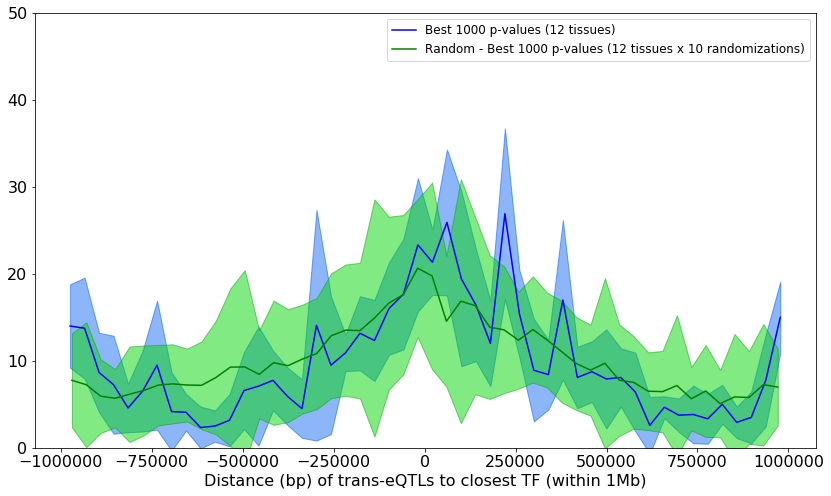

In [145]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

outfile = "../plots/multi_tissue_TF_distance_multirand_"+myexpr+"_"+mymethod+"_n"+paramline+".png"

fig = plt.figure(figsize=(14,8))
ax  = fig.add_subplot(111)
# GWSdists = [x.TFdist for x in GWSsnps]
# ax.hist(GWSdists, bins=Numbins, alpha=0.3, label="signif")
ax.plot(gwsx, gwsavgNcounts, label="Best 1000 p-values (12 tissues)", color="blue")
ax.fill_between(gwsx, gwsavgNcounts-gwsstdNcounts, gwsavgNcounts+gwsstdNcounts, alpha=0.6, edgecolor='#116bfc', facecolor='#4286f4')


# ax.plot(x, avgNcounts, label="non-signif avg", color='red')
# ax.fill_between(x, avgNcounts-stdNcounts, avgNcounts+stdNcounts, alpha=0.5, edgecolor='#e51d1d', facecolor='#ff4848')

ax.plot(Rgwsx, RgwsavgNcounts, label="Random - Best 1000 p-values (12 tissues x 10 randomizations)", color="green")
ax.fill_between(Rgwsx, RgwsavgNcounts-RgwsstdNcounts, RgwsavgNcounts+RgwsstdNcounts, alpha=0.5, edgecolor='#06a008', facecolor='#04d607')

ax.legend()
ax.set_ylim(bottom=0, top=50)
ax.set_xlabel("Distance (bp) of trans-eQTLs to closest TF (within 1Mb)")
plt.savefig(outfile, bbox_inches='tight')
plt.show()
